In [1]:
import matplotlib.pyplot as plt
import os
import torchaudio
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, SequentialSampler
from adasp_data_management import music

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-6

/home/ids/edabier/miniconda3/envs/amt-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
else:
    dev = "cpu"

### Load the ground truth dataset

In [6]:
# dataset_name    = "piano-dataset"
# dataset         = utils.NMFDataset(f"{dataset_name}/audios", f"{dataset_name}/midis", fixed_length=False, use_H=False, num_files=None)
# train_size      = 0.8

# train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, 1-train_size])

# train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
# valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False)

In [3]:
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata
dataset = utils.MapsDataset(metadata, fixed_length=False, subset=0.01, verbose=True)

Maps: load metadata file /tsi/mir/maps/metadata.csv
Computing the length of files...


359it [00:26, 13.50it/s]


In [26]:
from torch.utils.data import Sampler

class SequentialBatchSampler(Sampler):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size

    def __iter__(self):
        indices = list(range(len(self.data_source)))
        # Split indices into batches
        batches = [indices[i:i + self.batch_size] for i in range(0, len(indices), self.batch_size)]
        # Flatten the list of batches
        return iter(batches)

    def __len__(self):
        return len(self.data_source) // self.batch_size
    
def pad_by_repeating(tensor, max_length):
    if tensor.size(1) < max_length:
        repeat_times = int(np.ceil(max_length / tensor.size(1)))
        repeated_tensor = tensor.repeat(1, repeat_times)[:, :max_length]
        return repeated_tensor
    return tensor
    
def custom_collate(batch):
    # Separate audio and MIDI files
    audio_files = [item[0] for item in batch]
    midi_files = [item[1] for item in batch]
    
    max_audio_length = max(audio.size(1) for audio in audio_files)
    max_midi_length = max(midi.size(1) for midi in midi_files)

    # Pad audio and MIDI files by repeating their data
    audio_files_padded = torch.stack([pad_by_repeating(audio, max_audio_length) for audio in audio_files])
    midi_files_padded = torch.stack([pad_by_repeating(midi, max_midi_length) for midi in midi_files])

    # Return them as lists to avoid stacking
    return audio_files_padded, midi_files_padded

In [27]:
import random, time

train_size      = 0.8
batch_size = 16

sampler = SequentialBatchSampler(dataset, batch_size)
data_loader = DataLoader(dataset, batch_sampler=sampler, collate_fn=custom_collate)

# Create DataLoaders for training and validationw
train_loader = []
valid_loader = []

for i, batch in enumerate(data_loader):
    if i % 5 == 0:  # Every 5th batch goes to validation
        valid_loader.append(batch)
    else:
        train_loader.append(batch)
# train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, 1-train_size], generator=generator)

# sampler = SequentialSampler(dataset)
# train_loader = DataLoader(train_set, shuffle=False, collate_fn=utils.collate_fn, batch_size=batch_size)#, sampler=sampler)
# valid_loader = DataLoader(valid_set, shuffle=False, collate_fn=utils.collate_fn, batch_size=batch_size)#, sampler=sampler)
print(f"Train dataset: {len(train_loader)}, valid dataset: {len(valid_loader)}")

Train dataset: 18, valid dataset: 5


In [29]:
for M, H in train_loader:
    print(M.shape[2])

1551
1689
1689
1689
2437
2841
3242
3514
4322
4591
4925
5265
6005
6406
6746
7082
7756
19657


In [ ]:
import plotly.express as px

sizes = dataset.metadata["length"]
mean_size = np.mean(sizes)
std_size = np.std(sizes)

# Histogram with logarithmic scale
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(sizes, bins=100, alpha=0.7, color='blue', log=True)
plt.title('Logarithmic Distribution of File sizes')
plt.xlabel('Size')
plt.ylabel('Log(Frequency)')
plt.grid(True)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(sizes, vert=False, patch_artist=True)
plt.title('Box Plot of File sizes')
plt.xlabel('Size')
plt.grid(True)

plt.tight_layout()
plt.show()

### Create the model
`hidden`=`8`, `shared`=`True` => 1122 params

In [6]:
W_path = 'test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=10, n_init_steps=1, hidden=8, shared=True, return_layers=False)
utils.model_infos(ralmu, names=False)
ralmu

The model has 1122 parameters


RALMU(
  (layers): ModuleList(
    (0-9): 10 x RALMU_block(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.

### Train the model

In [7]:
optimizer   = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)
criterion   = nn.MSELoss()
# device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ralmu = ralmu.to(dev)
epochs      = 10

train1 = False
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)

# losses, W_warmup, H_warmup, H1 = utils.warmup_train(ralmu, n_epochs1, train_loader, optimizer1, device, debug=True)

losses, valid_losses, W_hat, H_hat = utils.train(ralmu, train_loader, optimizer, criterion, dev, epochs, valid_loader)

# spec.vis_cqt_spectrogram(ralmu.W0, np.arange(ralmu.W0.shape[1]), np.arange(ralmu.W0.shape[0]), 0, ralmu.W0.shape[1])
# spec.vis_cqt_spectrogram(W_warmup.detach(), np.arange(W_warmup.shape[1]), np.arange(W_warmup.shape[0]), 0, W_warmup.shape[1])
# spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1])

plt.plot(losses[1:], label='train loss')
plt.plot(valid_losses[1:], label='valid loss')
plt.ylabel("MSE")
plt.xlabel("epochs")
plt.legend()

RuntimeError: stack expects each tensor to be equal size, but got [288, 7550] at entry 0 and [288, 4812] at entry 2

In [ ]:
dataset_name = "piano-dataset"
W_path = 'test-data/synth-single-notes'
y, sr = torchaudio.load(f"{dataset_name}/audios/example-6.wav")
y = y.to(dev)

M, times, _ = spec.cqt_spec(y, sr, hop_length=128)
M = M.to(dev)

midi, onset, offset, _ = spec.midi_to_pianoroll(f"{dataset_name}/midis/example-6.mid", y, times,128,sr)
midi = midi.to(dev)
active_midi = [i for i in range(88) if (midi[i, :] > 0).any().item()]
H = init.MIDI_to_H(midi, active_midi, onset, offset)
H = H.to(dev)
W, _, _, _ = init.init_W(W_path)
W = W.to(dev)

In [5]:
model_path = 'models/RALMU.pt'
weights = torch.load(model_path)
weights.pop("H0")

ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=5, n_init_steps=1, hidden=8, shared=True, return_layers=False)

ralmu.load_state_dict(weights)
ralmu.init_H(M)

W_hat, H_hat, M_hat = ralmu.forward(M)
M_hat = M_hat.detach()

In [6]:
print(utils.compute_metrics(H_hat, H, threshold=1))

(0.004962779156327543, 0.0392156862745098, 0.008810572687224669, 0.02)


/var/folders/17/t6f3z0rd44jc522cqy2b5jzw0000gn/T/ipykernel_17345/3983643666.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_mu = init.init_H(l=88, t=M.shape[1], W=torch.tensor(W), M=M, n_init_steps=n_steps)
/var/folders/17/t6f3z0rd44jc522cqy2b5jzw0000gn/T/ipykernel_17345/3983643666.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = np.abs(M - M_hat)
/var/folders/17/t6f3z0rd44jc522cqy2b5jzw0000gn/T/ipykernel_17345/3983643666.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff_r = np.abs(M - M_mu)


Text(0.5, 1.0, 'diff with MU')

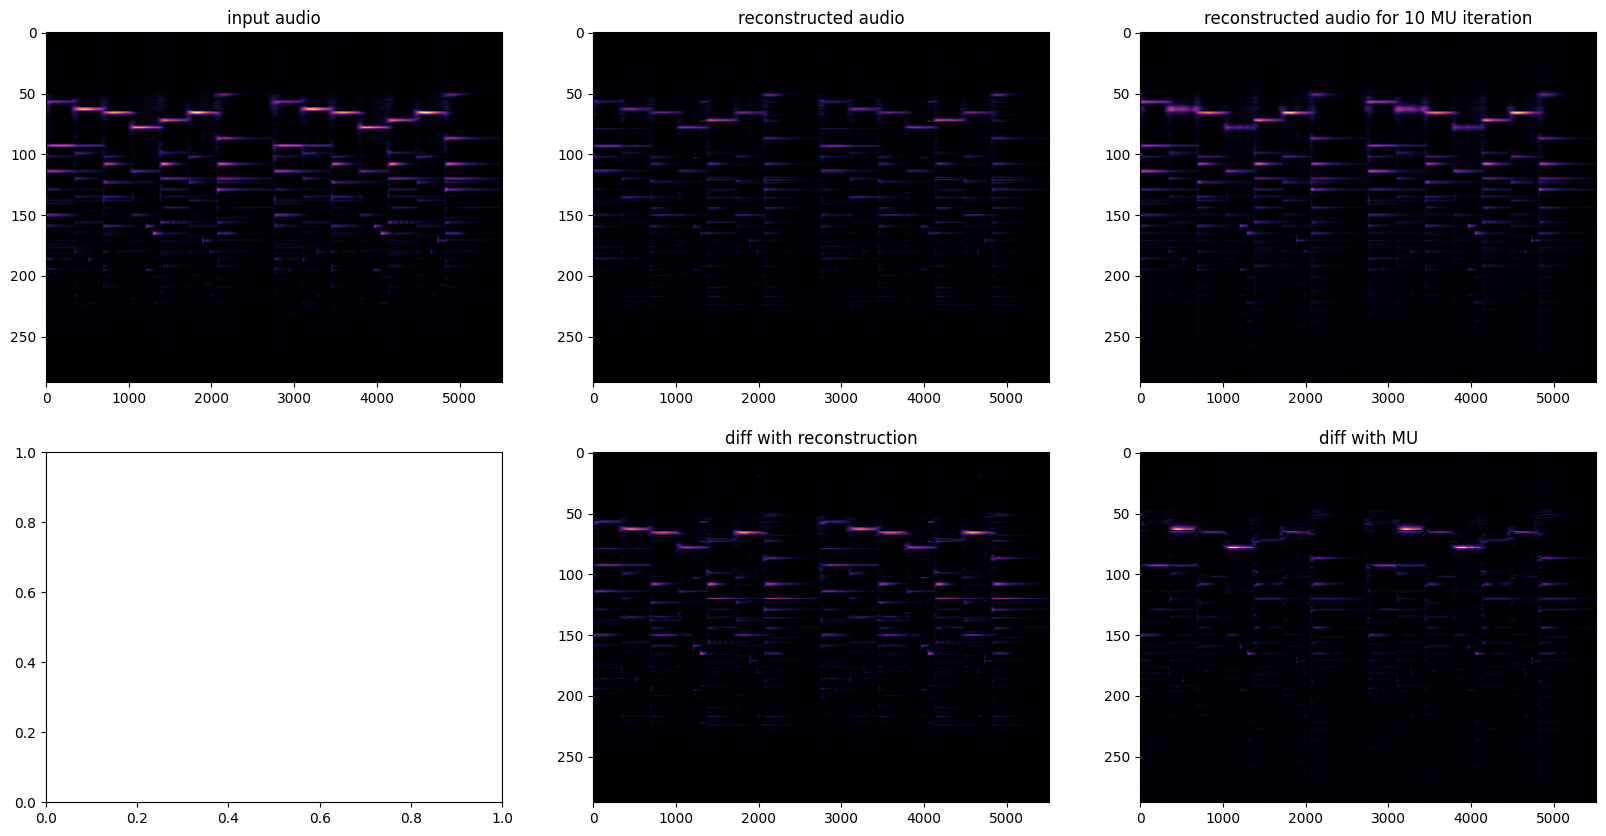

In [11]:
# M_n = np.apply_along_axis(lambda x: x / np.sum(np.abs(x)), axis=0, arr=M)
# M_hat_n = np.apply_along_axis(lambda x: x / np.sum(np.abs(x)), axis=0, arr=M_hat.detach())
n_steps = 10
H_mu = init.init_H(l=88, t=M.shape[1], W=torch.tensor(W), M=M, n_init_steps=n_steps)
M_mu = W @ H_mu

diff = np.abs(M - M_hat)
diff_r = np.abs(M - M_mu)
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0, 0].imshow(M, aspect="auto", cmap='magma')
ax[0, 0].set_title("input audio")

ax[0, 1].imshow(M_hat,  aspect="auto", cmap='magma')
ax[0, 1].set_title("reconstructed audio")

ax[0, 2].imshow(M_mu,  aspect="auto", cmap='magma')
ax[0, 2].set_title(f"reconstructed audio for {n_steps} MU iteration")

ax[1, 1].imshow(diff, aspect="auto", cmap='magma')
ax[1, 1].set_title("diff with reconstruction")

ax[1, 2].imshow(diff_r, aspect="auto", cmap='magma')
ax[1, 2].set_title("diff with MU")
# fig.colorbar(pos, ax=ax)

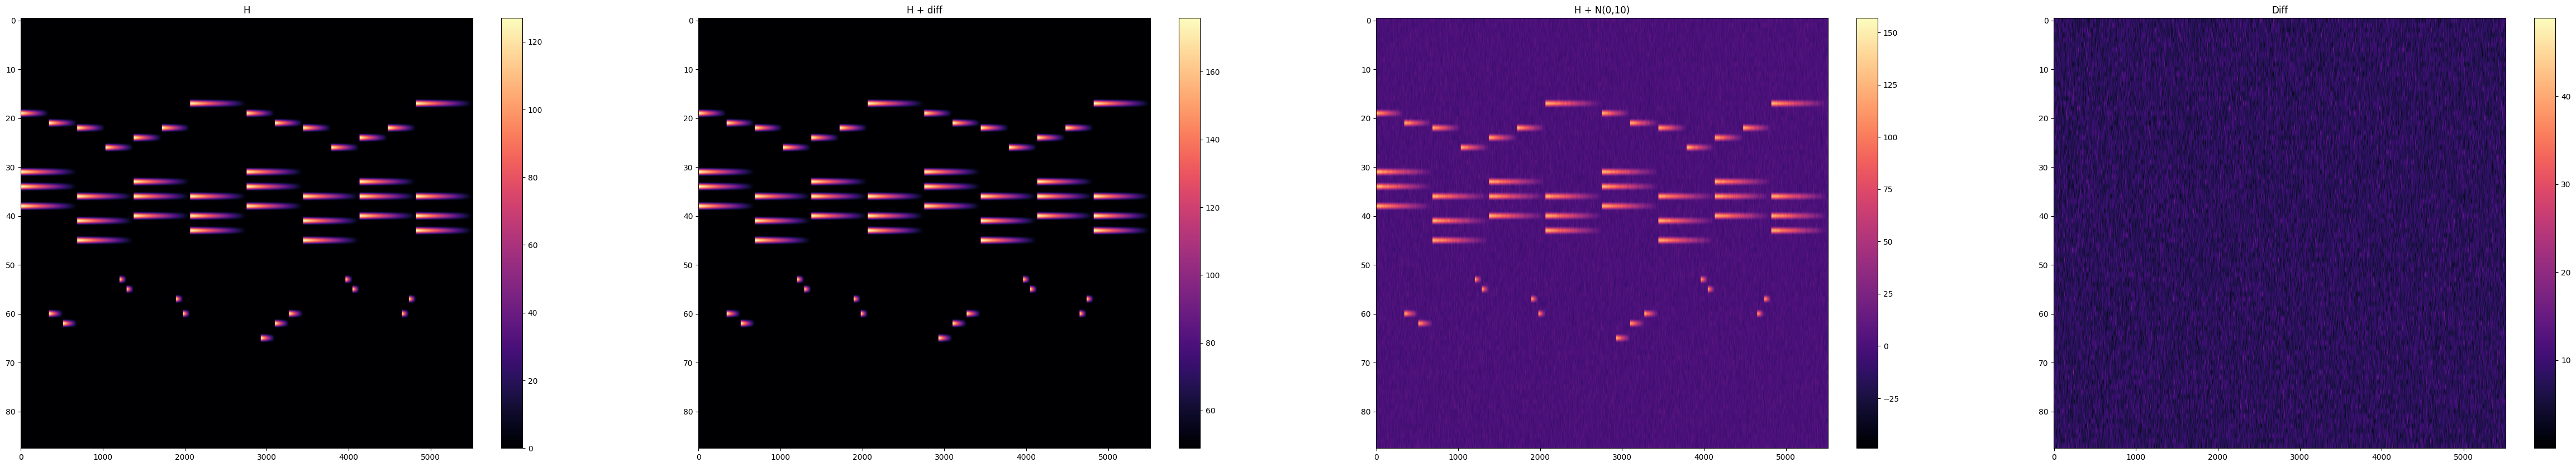

In [ ]:
sigma = 10
H_m = H + sigma*torch.randn(H.shape)
diff = torch.abs(H_m - H)
H_2 = H + diff.max()*torch.ones_like(H)

fig, ax = plt.subplots(1, 4, figsize=(60,10))

im1 = ax[0].imshow(H,  aspect="auto", cmap='magma')
ax[0].set_title("H")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(H_2,  aspect="auto", cmap='magma')
ax[1].set_title("H + diff")
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].imshow(H_m,  aspect="auto", cmap='magma')
ax[2].set_title(f"H + N(0,{sigma})")
fig.colorbar(im3, ax=ax[2])

im4 = ax[3].imshow(diff,  aspect="auto", cmap='magma')
ax[3].set_title("Diff")
fig.colorbar(im4, ax=ax[3])

In [23]:
import mir_eval
def compute_metrics(prediction, ground_truth, time_tolerance=0.05, threshold=0):
    """
    Compute the precision, recall, F-measure and the accuracy of the transcription using mir_eval
    """
    if prediction == []:
        return 0, 0, 0, 0
    
    gt_notes = extract_note_events(ground_truth)
    pred_notes = extract_note_events(prediction, threshold=threshold)
    
    if len(gt_notes) == 0 or len(pred_notes) == 0:
        return 0, 0, 0, 0
    
    gt_times = gt_notes[:,0:2]
    gt_pitch = gt_notes[:,2]
    
    pred_times = pred_notes[:,0:2]
    pred_pitch = pred_notes[:,2]
    
    if np.any(gt_pitch < 21) or np.any(pred_pitch < 21):
        raise ValueError("Pitch values must be valid MIDI notes (21 <= X <= 108).")

    prec, rec, f_mes, _ = mir_eval.transcription.precision_recall_f1_overlap(
        gt_times, gt_pitch, pred_times, pred_pitch, 
        offset_ratio = None, onset_tolerance = time_tolerance, pitch_tolerance = 0.1)

    return prec, rec, f_mes, gt_notes, pred_notes

def extract_note_events(piano_roll, threshold=0):
    """
    Creates a note_event object from a piano_roll tensor
    The note_event is a list of notes (start, end, pitch)
    """
    # Pad the tensor to handle edge cases
    padded_tensor = torch.zeros(piano_roll.shape[0], piano_roll.shape[1] + 2, device=piano_roll.device)
    padded_tensor[:, 1:-1] = piano_roll

    note_events = []
    note_starts = ((padded_tensor[:, :-1] <= threshold) & (padded_tensor[:, 1:] > threshold)).nonzero(as_tuple=True)
    note_ends = ((padded_tensor[:, :-1] > threshold) & (padded_tensor[:, 1:] <= threshold)).nonzero(as_tuple=True)

    # Iterate over each pitch and pair starts with ends
    for pitch in range(padded_tensor.shape[0]):
        starts = note_starts[1][note_starts[0] == pitch]
        ends = note_ends[1][note_ends[0] == pitch]

        # Pair each start with an end
        for start, end in zip(starts, ends):
            note_events.append([start.item(), end.item(), pitch+21])

    return np.array(note_events, dtype=np.int32).reshape(-1, 3)

prec, rec, f, gt_notes, pred_notes = compute_metrics(H_m, H, threshold=diff.max())
print(prec, rec, f, len(gt_notes), len(pred_notes))

0.04717853839037928 1.0 0.0901060070671378 51 1081


In [28]:
prec, rec, f, acc, gt_notes, pred_notes = utils.compute_metrics(H_m, H, threshold=diff.max())
print(prec, rec, f, acc, len(pred_notes), len(gt_notes))

0.3893129770992366 1.0 0.5604395604395604 1.0 131 51


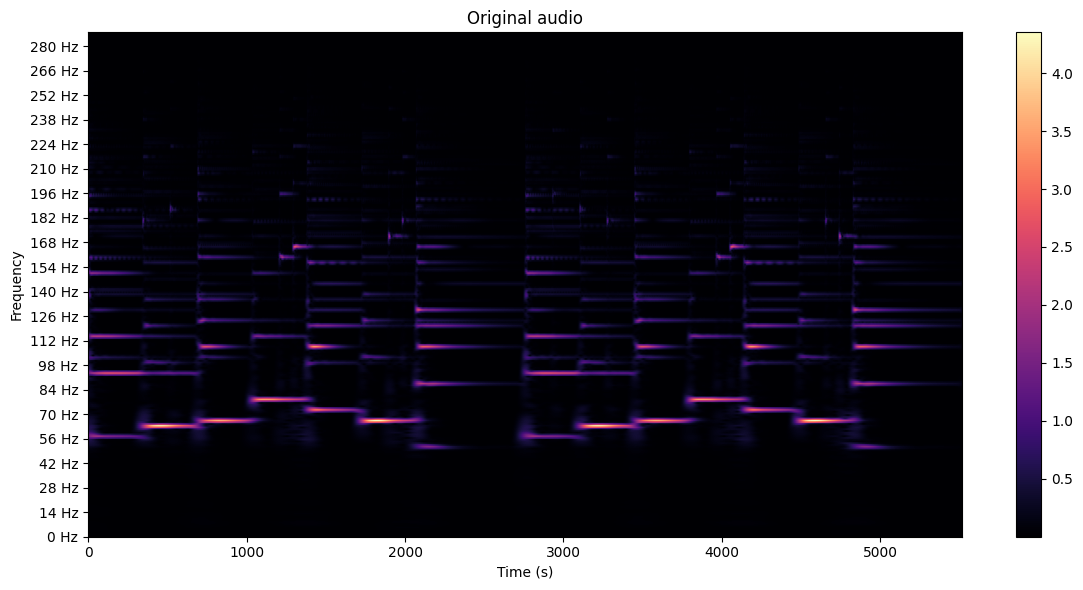

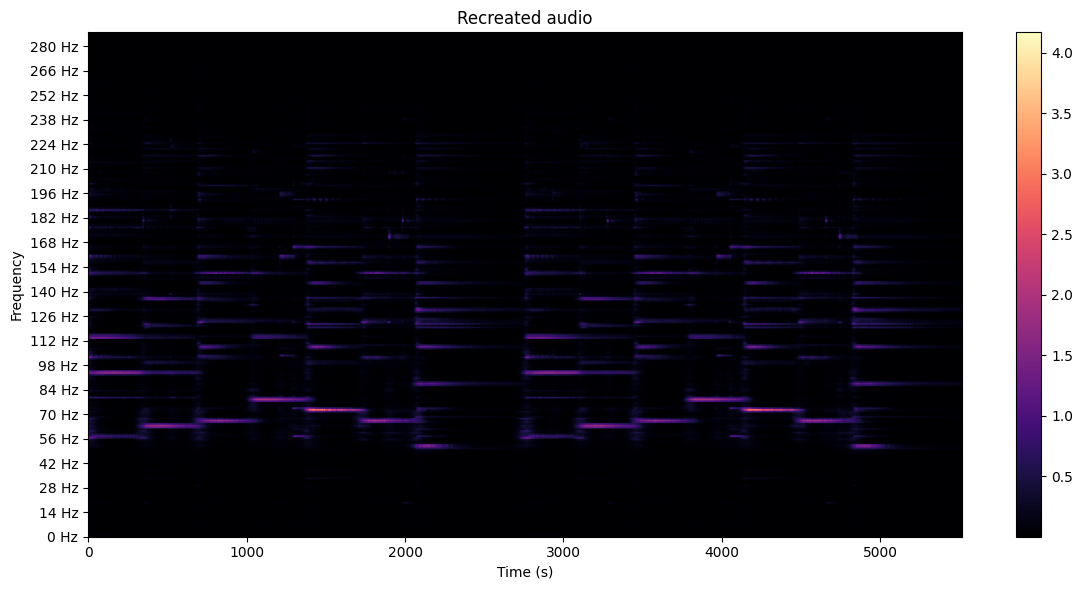

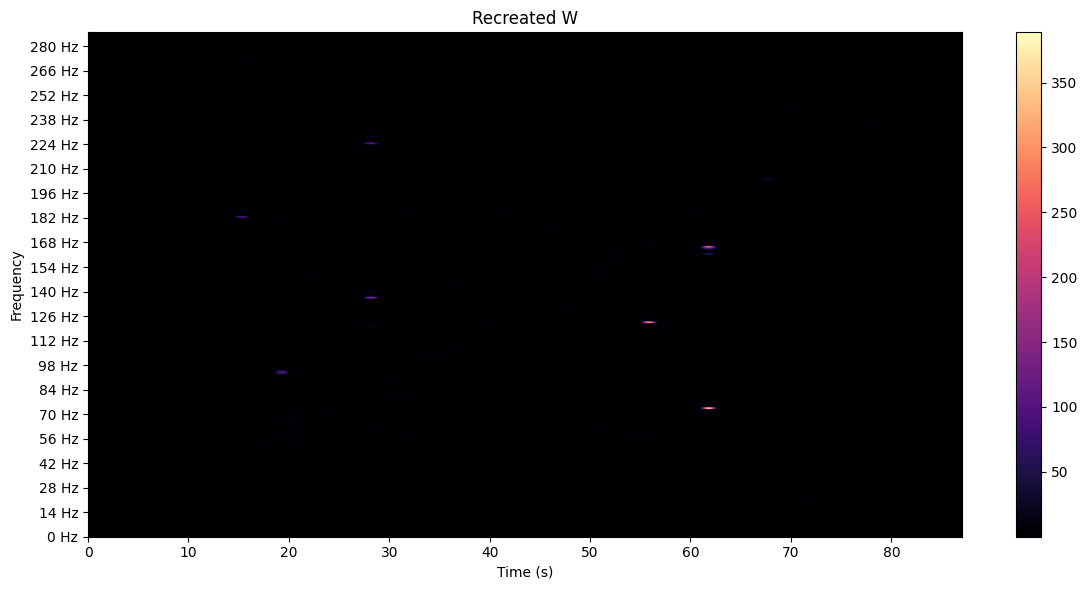

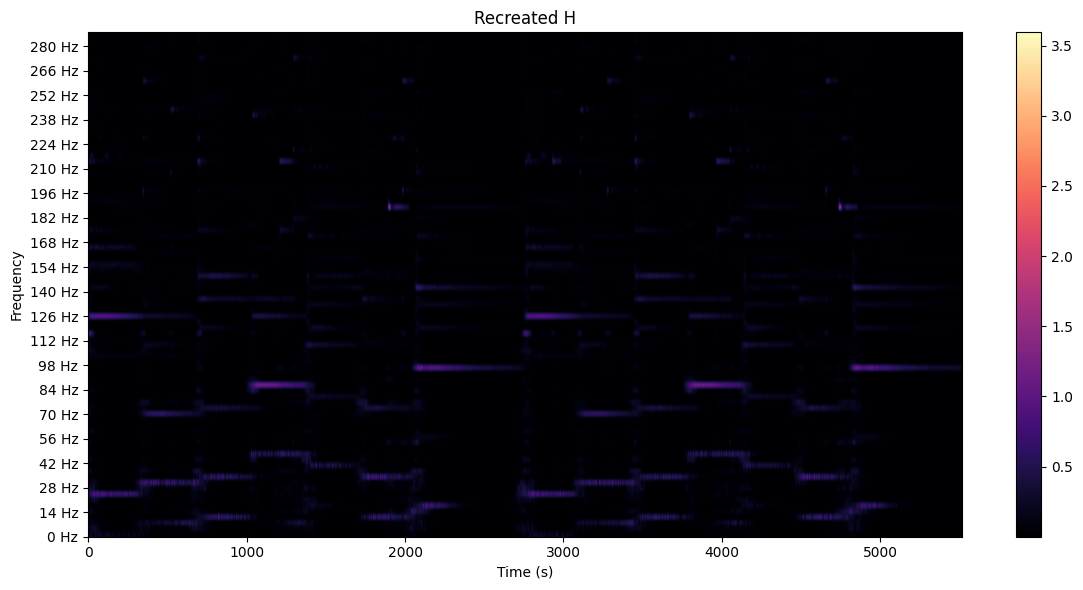

In [35]:
times = np.arange(M.shape[1])
freqs = np.arange(M.shape[0])

spec.vis_cqt_spectrogram(M, times, freqs, 0, times[-1], title="Original audio")
spec.vis_cqt_spectrogram(M_hat.detach(), times, freqs, 0, times[-1], title="Recreated audio")
spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(88), freqs, 0, 88, title="Recreated W")
spec.vis_cqt_spectrogram(H_hat.detach(), times, freqs, 0, times[-1], title="Recreated H")